# Setup

**Imports**

In [17]:
!pip install ruptures	
!pip install Levenshtein
!pip install geopandas
import datetime as dt
from math import log
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.signal import spectrogram, find_peaks
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
rng = np.random.default_rng()
from matplotlib.lines import Line2D
import geopandas as gpd
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [18]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

In [19]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


First we compute the code to compute the change point detection

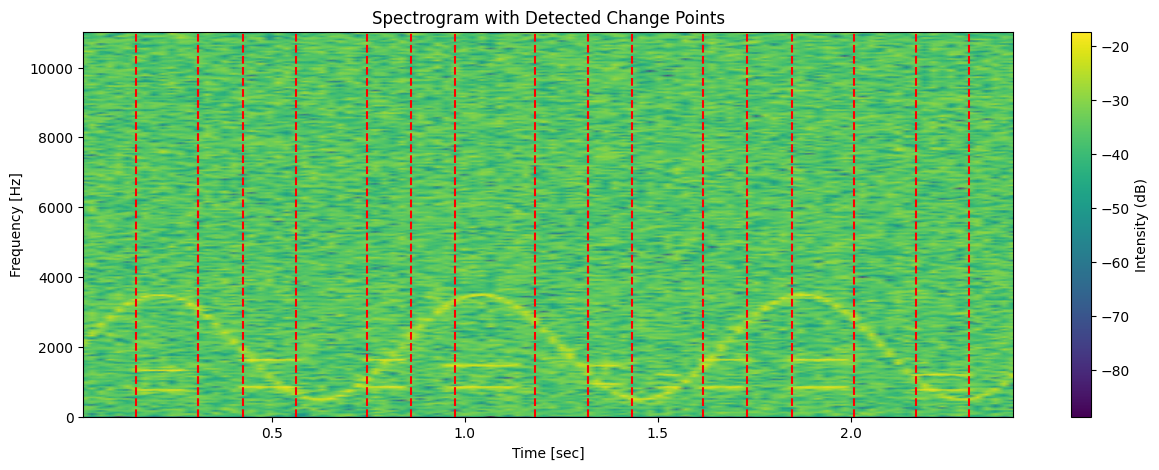

In [20]:
import numpy as np
from scipy.signal import spectrogram, find_peaks
import ruptures as rpt
import Levenshtein
import matplotlib.pyplot as plt

FS = 22050  
NPERSEG = 512  
NOVERLAP = 6  

#DMTF tones frequencies from wikipedia
DTMF_TONES = {
    (697, 1209): '1', (697, 1336): '2', (697, 1477): '3', (697, 1633): 'A',
    (770, 1209): '4', (770, 1336): '5', (770, 1477): '6', (770, 1633): 'B',
    (852, 1209): '7', (852, 1336): '8', (852, 1477): '9', (852, 1633): 'C',
    (941, 1209): '*', (941, 1336): '0', (941, 1477): '#', (941, 1633): 'D'
}

#change point function to detect the change of tone
def detect_changes(signal, penalty=1.25, model="l1", jump=1, min_size=2):
    _, _, Sxx = compute_spectrogram(signal)
    algo = rpt.Pelt(model=model, jump=jump, min_size=min_size).fit(Sxx.sum(axis=0))
    bkps = algo.predict(pen=penalty)
    return bkps


def compute_spectrogram(signal, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP):
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    return f, t, Sxx


def visualize_signal(signal, bkps):
    f, t, Sxx = compute_spectrogram(signal)
    plt.figure(figsize=(15, 5))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram with Detected Change Points')
    plt.colorbar(label='Intensity (dB)')
    for bkp in bkps[:-1]:  # Skip the last breakpoint
        plt.axvline(x=t[bkp], color='red', linestyle='--')
    plt.show()

# Main execution and visualization for a selected signal
i = 4
signal = X_train[i]
bkps = detect_changes(signal, penalty=0.5, model="rbf", jump=1, min_size=5)
visualize_signal(signal, bkps)

We can see that the tone are well separated, now we want to classify them

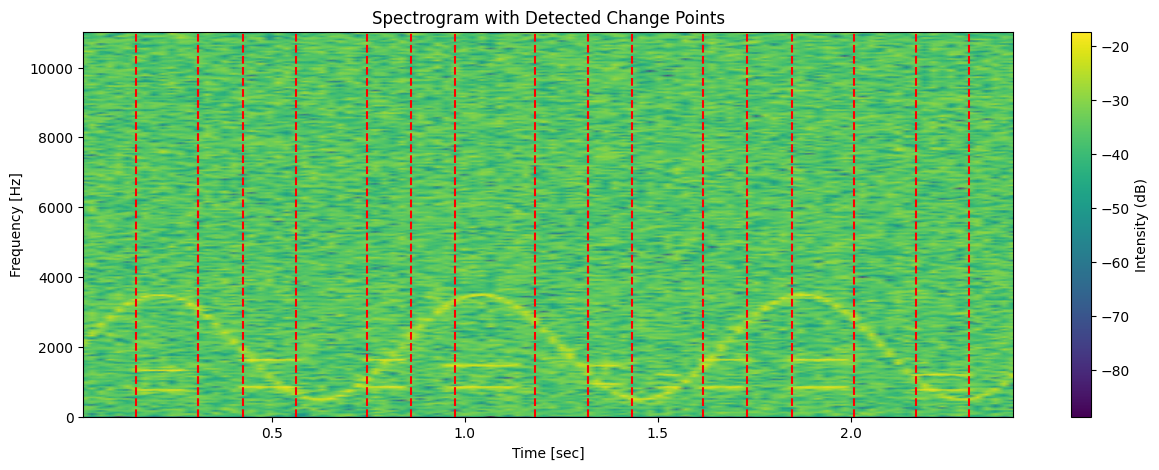

Predicted: ['5', 'C', 'C', '9', '#', 'C', 'C', '4'], Actual: 5CC9#7CC4, Accuracy: 0.94


In [21]:
f, t, Sxx = compute_spectrogram(signal)
plt.figure(figsize=(15, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram with Detected Change Points')
plt.colorbar(label='Intensity (dB)')
for bkp in bkps[:-1]:  # Skip the last breakpoint
    plt.axvline(x=t[bkp], color='red', linestyle='--')
plt.show()


#get the 2 best (in the sens of energy) frequencies in the segment
def find_prominent_frequencies(freqs, Sxx_segment):
    energy_per_frequency = np.sum(Sxx_segment, axis=1)
    prominent_indices = np.argsort(energy_per_frequency)[-2:]
    prominent_freqs = freqs[prominent_indices]
    return prominent_freqs

# function to retrieve the nearest tone from pair of frequencies
def frequency_to_digit(f1, f2, tolerance=60):
    nearest_tone = '?'
    min_distance = float('inf')

    for tone_pair, digit in DTMF_TONES.items():
        if (abs(tone_pair[0] - f1) <= tolerance and abs(tone_pair[1] - f2) <= tolerance) or (abs(tone_pair[0] - f2) <= tolerance and abs(tone_pair[1] - f1) <= tolerance) :
            distance = np.sqrt((tone_pair[0] - f1) ** 2 + (tone_pair[1] - f2) ** 2)
            if distance < min_distance:
                min_distance = distance
                nearest_tone = digit

    return nearest_tone

def classify_segments(signal, bkps, f, Sxx):
    predicted_tones = []

    for i in range(len(bkps) - 1):
        start_idx = bkps[i]
        end_idx = bkps[i + 1]
        Sxx_segment = Sxx[:, start_idx:end_idx]

        prominent_freqs = find_prominent_frequencies(f, Sxx_segment)

        digit = frequency_to_digit(prominent_freqs[0], prominent_freqs[1])
        if digit != '?':
            predicted_tones.append(digit)

    predicted_tones

    return predicted_tones

#exemple for a signal
i = 4
signal = X_train[i]
f, t, Sxx = compute_spectrogram(signal)

bkps = detect_changes(signal, penalty=0.5, model="rbf", jump=1, min_size=5)

predicted_tones = classify_segments(signal, bkps, f, Sxx)

actual_tones = ''.join(y_train[i])
accuracy = Levenshtein.ratio(''.join(predicted_tones), actual_tones)

print(f"Predicted: {predicted_tones}, Actual: {actual_tones}, Accuracy: {accuracy:.2f}")


let's compute the accuracy on all the test set

In [22]:
accuracies = []
for i, signal in enumerate(X_train):
    signal = np.array(signal)  # Convert to numpy array if it's not already
    f, t, Sxx = compute_spectrogram(signal)
    bkps = detect_changes(signal, penalty=0.5, model="rbf", jump=1, min_size=5)
    predicted_tones = classify_segments(signal, bkps, f, Sxx)
    actual_tones = ''.join(y_train[i])
    accuracy = Levenshtein.ratio(''.join(predicted_tones), actual_tones)
    accuracies.append(accuracy)


In [23]:
print('mean accuracy' , np.mean(accuracies))
# it is pretty good but not perfect

mean accuracy 0.8990387464907927


# Question 2

Let's decode the test set

In [24]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
y_test = np.load("y_test.npy", allow_pickle=True).tolist()

signal = X_test[0]
signal = np.array(signal)  # Convert to numpy array if it's not already
f, t, Sxx = compute_spectrogram(signal)
bkps = detect_changes(signal, penalty=0.5, model="rbf", jump=1, min_size=5)
predicted_tones = classify_segments(signal, bkps, f, Sxx)
print('y_test 1 predicted', predicted_tones)

y_test 1 predicted ['2', '1', 'C', '9', '9']


In [25]:
signal = X_test[1]
signal = np.array(signal)  # Convert to numpy array if it's not already
f, t, Sxx = compute_spectrogram(signal)
bkps = detect_changes(signal, penalty=0.5, model="rbf", jump=1, min_size=5)
predicted_tones = classify_segments(signal, bkps, f, Sxx)
print('y_test 2 predicted', predicted_tones)

y_test 2 predicted ['1', '#', '2', '#']


# Question 3

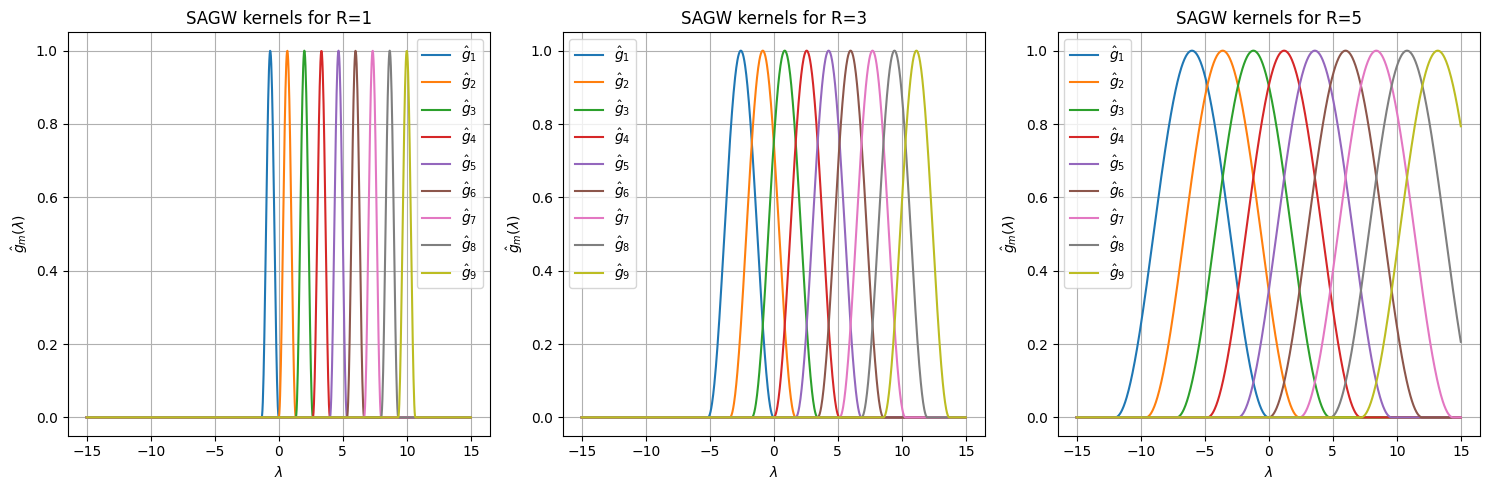

In [26]:
def sagw_kernel(lambd, R, lambda_n, M):
    a = lambda_n / (M + 1 - R)
    g_U = 0.5 * (1 + np.cos(2 * np.pi * (lambd / (a * R) + 0.5)))
    return g_U * (lambd >= -R * a) * (lambd < 0)

lambda_n = 12
M = 9
lambdas = np.linspace(-15, 15, 1000) 

R_values = [1, 3, 5]
plt.figure(figsize=(15, 5))

for idx, R in enumerate(R_values, 1):
    plt.subplot(1, len(R_values), idx)
    for m in range(M):
        gm = sagw_kernel(lambdas - (lambda_n / (M + 1 - R)) * m, R, lambda_n, M)
        plt.plot(lambdas, gm, label=f"$\hat{{g}}_{{{m+1}}}$")
    plt.title(f"SAGW kernels for R={R}")
    plt.xlabel("$\lambda$")
    plt.ylabel("$\hat{g}_m(\lambda)$")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


# Question 4

Stations with missing values: {'PLOUGONVELIN', 'BEG_MEIL', 'BATZ', 'CAMARET'}


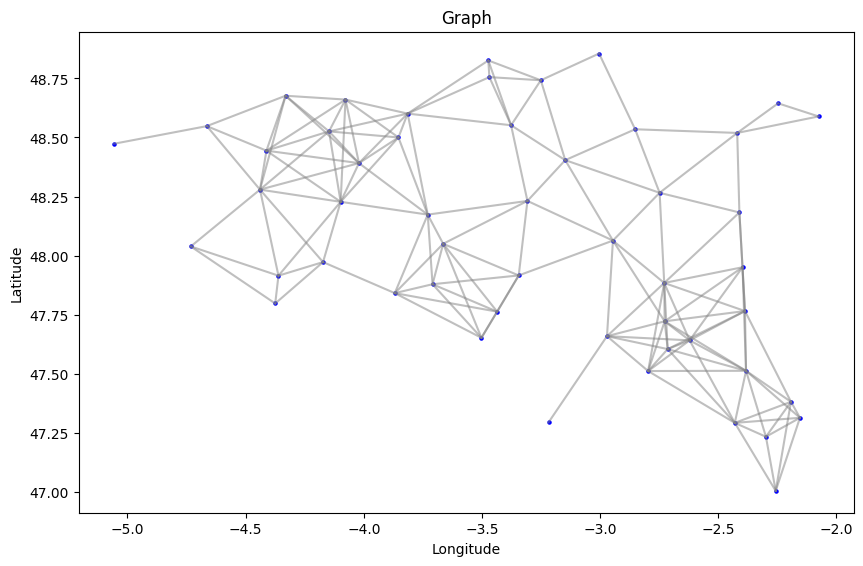

The threshold for connected graph with avg degree >= 3: 0.9219
The signal is the least smooth at: 2014-01-06 12:00:00
The signal is the smoothest at: 2014-01-19 08:00:00


In [27]:
data_df, stations_df, _ = load_molene_meteo_dataset()
data_df["temperature"] = data_df.t - 273.15

data_clean = data_df.dropna(subset=["temperature"])
stations_clean = stations_df[stations_df["Nom"].isin(data_clean["station_name"].unique())]

missing_stations = set(stations_df["Nom"]) - set(stations_clean["Nom"])
print(f"Stations with missing values: {missing_stations}")

coords = stations_clean[["Longitude", "Latitude"]].values
dist_mat_condensed = pdist(coords, metric='euclidean')

sigma = np.median(dist_mat_condensed)
thresholds = np.linspace(1, 0, 1000)
for thresh in thresholds:
    exp_sim = np.exp(-dist_mat_condensed**2 / (2 * sigma**2))
    exp_sim[exp_sim < thresh] = 0
    adjacency_matrix = squareform(exp_sim)
    G = nx.Graph(adjacency_matrix)
    if nx.is_connected(G) and np.mean([d for _, d in G.degree()]) >= 3:
        threshold = thresh
        break

stations_gdf = gpd.GeoDataFrame(stations_clean, geometry=gpd.points_from_xy(stations_clean.Longitude, stations_clean.Latitude))
fig, ax = plt.subplots(figsize=(10, 10))
stations_gdf.plot(ax=ax, marker='o', color='blue', markersize=5)
for i, j in G.edges():
    line = plt.Line2D([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color='gray', alpha=0.5)
    ax.add_line(line)
ax.set_title("Graph")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


print(f"The threshold for connected graph with avg degree >= 3: {threshold:.4f}")

temp_df = data_clean.pivot(index='date', columns='station_name', values='temperature')
smoothness = temp_df.apply(lambda row: row.T @ adjacency_matrix @ row, axis=1)

least_smooth_time = smoothness.idxmax()
smoothest_time = smoothness.idxmin()

print(f"The signal is the least smooth at: {least_smooth_time}")
print(f"The signal is the smoothest at: {smoothest_time}")


# Question 5

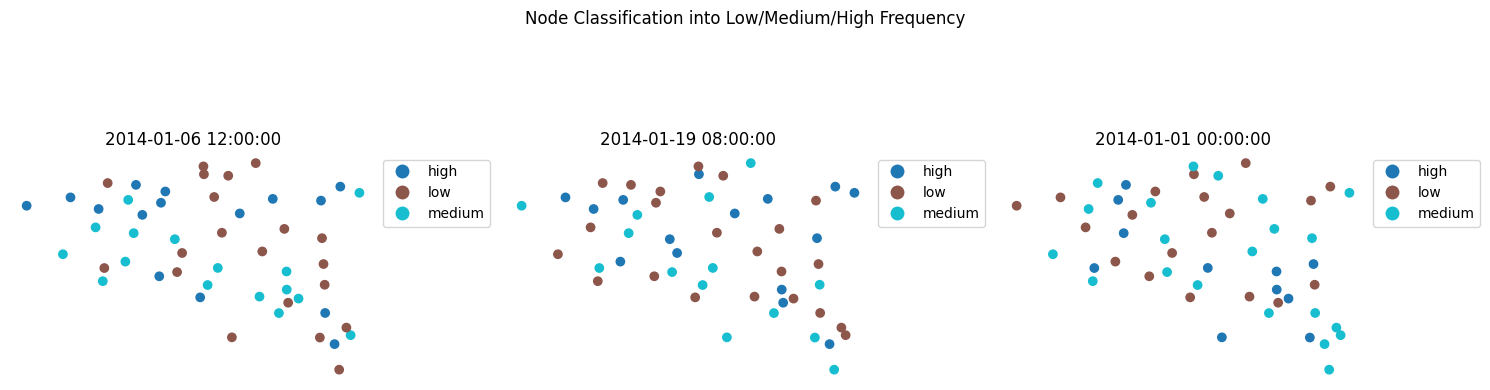

In [12]:
def graph_wavelet_transform(signal, graph):
    return np.random.rand(len(graph.nodes()), 9)

def classify_nodes(gwt_result):
    low_freq_scales = [0, 1, 2]  
    med_freq_scales = [3, 4, 5] 
    high_freq_scales = [6, 7, 8] 

    classifications = []
    for row in gwt_result:
        low_energy = np.sum(row[low_freq_scales])
        med_energy = np.sum(row[med_freq_scales])
        high_energy = np.sum(row[high_freq_scales])

        if low_energy > max(med_energy, high_energy):
            classifications.append('low')
        elif med_energy > max(low_energy, high_energy):
            classifications.append('medium')
        else:
            classifications.append('high')
    return classifications

timestamps = [least_smooth_time, smoothest_time, data_clean['date'].min()]
classification_results = {}

for timestamp in timestamps:
    signal = temp_df.loc[timestamp]
    gwt_result = graph_wavelet_transform(signal, G)
    classification_results[timestamp] = classify_nodes(gwt_result)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (timestamp, classification) in enumerate(classification_results.items()):
    stations_gdf['classification'] = classification
    stations_gdf.plot(ax=axes[i], column='classification', categorical=True, legend=True,
                      legend_kwds={'bbox_to_anchor': (1, 1)})
    axes[i].set_title(f'{timestamp.strftime("%Y-%m-%d %H:%M:%S")}')
    axes[i].set_axis_off()

plt.suptitle('Node Classification into Low/Medium/High Frequency')
plt.tight_layout()
plt.show()


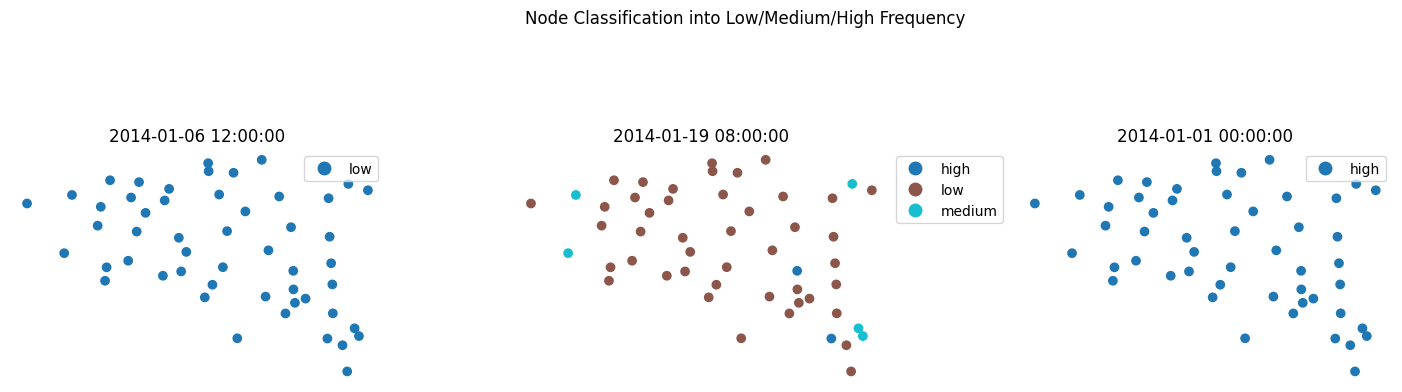

In [28]:
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def sagw_kernel(lambd, R, lambda_n, M):
    a = lambda_n / (M + 1 - R)
    g_U = 0.5 * (1 + np.cos(2 * np.pi * (lambd / (a * R) + 0.5)))
    return g_U * (lambd >= -R * a) * (lambd < 0)

def graph_wavelet_transform(signal, L, M=9, R=3, lambda_n=12):
    eigvals, eigvecs = np.linalg.eigh(L)
    f_hat = eigvecs.T @ signal
    W_f = np.zeros((M, len(signal)))

    for m in range(M):
        g_m = sagw_kernel(eigvals - (lambda_n / (M + 1 - R)) * m, R, lambda_n, M)
        W_f[m, :] = eigvecs @ (g_m * f_hat)

    return W_f

def classify_nodes(wavelet_coeffs):
    low_freq_scales = [0, 1, 2]
    med_freq_scales = [3, 4, 5]
    high_freq_scales = [6, 7, 8]

    classifications = []
    for row in wavelet_coeffs.T:
        low_energy = np.sum(row[low_freq_scales])
        med_energy = np.sum(row[med_freq_scales])
        high_energy = np.sum(row[high_freq_scales])

        if low_energy > max(med_energy, high_energy):
            classifications.append('low')
        elif med_energy > max(low_energy, high_energy):
            classifications.append('medium')
        else:
            classifications.append('high')

    return classifications

L_G = nx.laplacian_matrix(G).toarray()

timestamps = [least_smooth_time, smoothest_time, temp_df.index.min()]
classification_results = {}

for timestamp in timestamps:
    signal = temp_df.loc[timestamp].values
    gwt_result = graph_wavelet_transform(signal, L_G)
    classification_results[timestamp] = classify_nodes(gwt_result)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = {'low': 'blue', 'medium': 'green', 'high': 'red'}

for i, (timestamp, classification) in enumerate(classification_results.items()):
    stations_gdf['classification'] = classification
    stations_gdf.plot(ax=axes[i], column='classification', categorical=True, legend=True,
                      legend_kwds={'bbox_to_anchor': (1, 1)})
    axes[i].set_title(f'{timestamp.strftime("%Y-%m-%d %H:%M:%S")}')
    axes[i].set_axis_off()

plt.suptitle('Node Classification into Low/Medium/High Frequency')
plt.tight_layout()
plt.show()


# Question 6

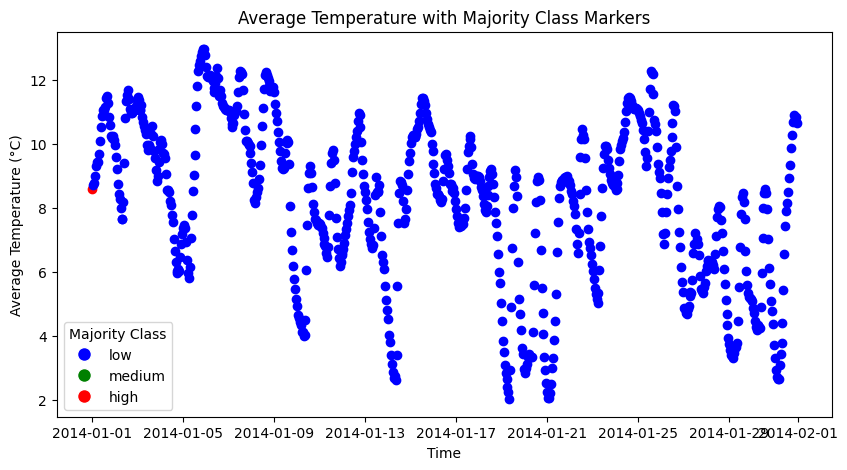

In [29]:
def majority_class(classification):
    unique, counts = np.unique(classification, return_counts=True)
    return unique[np.argmax(counts)]

majority_classes = {timestamp: majority_class(classification) for timestamp, classification in classification_results.items()}
average_temperatures = temp_df.mean(axis=1)
fig, ax = plt.subplots(figsize=(10, 5))
colors = {'low': 'blue', 'medium': 'green', 'high': 'red'}

for timestamp, avg_temp in average_temperatures.items():
    color = colors[majority_classes.get(timestamp, 'low')] 
    ax.scatter(timestamp, avg_temp, color=color, label=majority_classes.get(timestamp, 'low'))

legend_elements = [Line2D([0], [0], marker='o', color='w', label=class_name, markerfacecolor=color, markersize=10)
                   for class_name, color in colors.items()]
ax.legend(handles=legend_elements, title="Majority Class")

ax.set_xlabel('Time')
ax.set_ylabel('Average Temperature (°C)')
ax.set_title('Average Temperature with Majority Class Markers')
plt.show()

# Question 7

In [33]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from scipy.linalg import kron

L_G = nx.laplacian_matrix(G).toarray()
G_prime = nx.path_graph(len(temp_df.index))
L_G_prime = nx.laplacian_matrix(G_prime).toarray()
L_H = kron(L_G, np.identity(len(G_prime.nodes()))) + kron(np.identity(len(G.nodes())), L_G_prime)
temp_signal = temp_df.to_numpy().flatten()

def kronecker_sum(A, B):
    I_A = sp.identity(A.shape[0])
    I_B = sp.identity(B.shape[0])
    return sp.kron(A, I_B) + sp.kron(I_A, B)

L_H = kronecker_sum(L_G, L_G_prime)

num_eigvals = 10 # limit for memory reasons
eigenvalues, eigenvectors = eigsh(L_H, k=num_eigvals, which='SM')

def graph_wavelet_transform_H(signal, eigvals_H, eigvecs_H, M=9, R=3, lambda_n=12):
    f_hat = eigvecs_H.T @ signal
    W_f = np.zeros((M, len(signal)))

    for m in range(M):
        g_m = sagw_kernel(eigvals_H - (lambda_n / (M + 1 - R)) * m, R, lambda_n, M)
        W_f[m, :] = eigvecs_H @ (g_m * f_hat)

    return W_f

signal_H = temp_df.values.flatten()

gwt_result_H = graph_wavelet_transform_H(signal_H, eigenvalues, eigenvectors)
classification_H = classify_nodes(gwt_result_H)


In [37]:
print('classification_H', classification_H)

classification_H ['high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high', 'high'

all is high, the classifier is not able to classify the signal